# __ACA dark current map__

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import numpy.ma as ma
import collections
from Ska.Matplotlib import plot_cxctime

### Contents ###

* Simulate <code>IMGROW0</code>, <code>IMGCOL0</code> response to dither.
* Compute background image based on edge pixel values sampled by dither.
* Simulate telemetry in <code>aca_l0</code> format.
* Dark current map.
* Centroids.
* Plotting functions.
* Examples: simulated case with 1 hot pixel.
* Example: real data (HRC, dither amplitude 20 arcsec as opposed to 8 arcsec for ACIS).

### <code>IMGROW0</code>, <code>IMGCOL0</code> response to dither###

__Note 1.__ This is relevant only for simulations. Some prescription of dither needs to be introduced, to move around the ACA window and simulate the on-the-fly dynamic background construction and centroiding. For the real data, <code>IMGROW0</code>, <code>IMGCOL0</code> are read from the <code>aca_l0</code> file.

__Note 2.__ In reality, this response depends likely on the next anticipated centroid position because <code>IMGROW0</code>, <code>IMGCOL0</code> time behaviour differs among the slots. - I am using difference between real centroids and yaw/pitch? If I used the difference between the computed centroids and yaw/pitch then disturbing the centroids by the hot pixels would be accounted for.

Simulated <code>IMGROW0</code> and <code>IMGCOL0</code> are defined so that they respond to the dither pathern (yaw, pitch). Here this response is defined so that the difference between yaw and <code>IMGROW0</code>, and pitch and <code>IMGCOL0</code> is always < 1 pixel to keep star image near the center of the 8x8 window.

Below, this algorithm is checked against real data (obsid 50804).

In [2]:
obsid = 50804
slot = 3
dwell = events.dwells.filter(obsid=obsid)[0]
slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
time = slot_data['TIME']
row0 = slot_data['IMGROW0']
col0 = slot_data['IMGCOL0']

In [3]:
# Dither parameters, ACIS
ampl_yaw = 8. * u.arcsec
ampl_pitch = 8. * u.arcsec
pxsize = 5. * u.arcsec # per pixel
period_yaw = 1000.0 # sec
period_pitch = 707.1 # sec

# "Fit" parameters (depend on obsid and slot)
phase_yaw = 0.9 # in 2 pi
phase_pitch = 0.75 # in 2 pi
delta = 0.25 # px

yaw = ampl_yaw / pxsize * np.sin(2 * np.pi * time / period_yaw + 2 * np.pi * phase_yaw)
pitch = ampl_pitch / pxsize * np.sin(2 * np.pi * time / period_pitch + 2 * np.pi * phase_pitch)

sim_row0 = np.array(np.round(yaw - delta), dtype=np.int)
sim_col0 = np.array(np.round(pitch - delta), dtype=np.int)

print np.sum(yaw - sim_row0 > 1), np.sum(pitch - sim_col0 > 1)

0 0


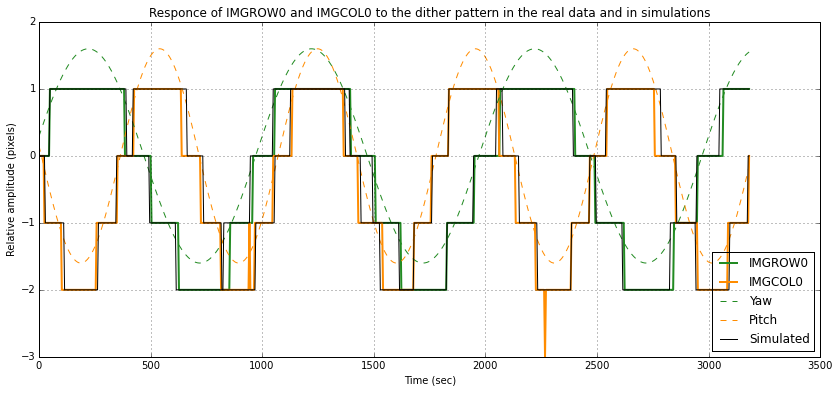

In [4]:
plt.figure(figsize=(14, 6))

plt.plot(time - time[0], row0 - row0[0], 'forestgreen', lw=2, label='IMGROW0')
plt.plot(time - time[0], col0 - col0[0], 'darkorange', lw=2, label='IMGCOL0')
plt.plot(time - time[0], yaw, 'forestgreen', ls='--', label='Yaw')
plt.plot(time - time[0], pitch, 'darkorange', ls='--', label='Pitch')

plt.plot(time - time[0], sim_row0, 'k')
plt.plot(time - time[0], sim_col0, 'k', label='Simulated')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel("Time (sec)")
plt.ylabel("Relative amplitude (pixels)")
plt.title('Responce of IMGROW0 and IMGCOL0 to the dither pattern in the real data and in simulations');

### Construct background image using sampled edge pixel values###

Compute background image for each time frame. Considered cases include:

* Current algorithm: assign average background value telemetered in <code>aca_l0</code> to each pixel, independantly of its real value (<code>bgd = 'bgdavg'</code>).


* Store the real value of each sampled edge pixel, and telemetered average background value for the remaining pixels. Use the median of n stored values for each pixel to compute the current background image (<code>bgd = 'mixed'</code>).

    1. __Patch S/ Survey.__ Use n "searches" to identify hot pixels and build a background map with hot pixels. Use this map when subtracting background from each time frame.
    
    1. __Patch D/ Dynamic List.__ Detect hot pixels on-the-fly while tracking (as the S/C is dithering). Use n latest pixel samples.
    

In [5]:
#   For each image, pick out the 'X's
#
#   (currently: option *8x8*, *6x6*, redefine r, c in get_centroids to compute **8x8**)
#
#    *8x8*              *6x6*
#
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  X......X  |        X....X
#   |/ X......X  |/       X....X
#      X......X           X....X
#      X......X           X....X
#      X......X           .XXXX.
#      X......X
#      XXXXXXXX
#      (2)--->
#
# OR
#
#    **8x8**
#
#      (1)--->
#  (3) XXXXXXXX (4)
#   |  XXXXXXXX  |
#   |/ XX....XX  |/
#      XX....XX
#      XX....XX
#      XX....XX
#      XXXXXXXX
#      XXXXXXXX
#      (2)--->

### Background image classes ###

In [6]:
# Background image always 8x8 ?

# Standard background, current algorithm
class StandardBgd(object):
    
    def __init__(self, bgdavg=0):
        self.img_size = 8
        self.bgdavg = bgdavg
    
    def __repr__(self):
        return ('<{} img_size={} bgdavg={}>'
                .format(self.__class__.__name__, self.img_size, self.bgdavg))
    
    def get_background(self):
        return np.ones((self.img_size, self.img_size)) * self.bgdavg # 8x8

    
class DynamBgd_Median(object):

    def __init__(self, img_size, ndeque=1000, deque_dict=None, img=None, row0=0, col0=0, bgdavg=0):

        self.img_size = img_size
        self.ndeque = ndeque
        self.deque_dict = deque_dict
        if self.deque_dict is None:
            self.deque_dict = collections.OrderedDict()
        self.img = img
        self.row0 = row0
        self.col0 = col0
        self.bgdavg = bgdavg
        
        if self.img_size == 8:
            self.r = [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]
            self.c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]
        else:
            self.r = [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 1, 2, 3, 4, 1, 2, 3, 4]
            self.c = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 5, 5, 5, 5]

        self.edge_descritpion = '1px outmost edge'
            
            
    def __repr__(self):
        return ('<{} img_size={} ndeque={} row0={} col0={} bgdavg={} edge_description={}>'
                .format(self.__class__.__name__, self.img_size, self.ndeque,
                        self.row0, self.col0, self.bgdavg, self.edge_descritpion))


    def get_background(self):

        if self.img is None:
            raise ValueError("DarkCurrent_Median_Bgd:: Can't compute background, img is None")
        
        bgd_img = np.zeros((8, 8))
        
        self.deque_dict = self.update_deque_dict()
        
        for rr in range(self.img_size):
            for cc in range(self.img_size):
                key = (rr + self.row0, cc + self.col0)
                if key in self.deque_dict.keys():
                    bgd_img[rr, cc] = self._get_value(key)
                else:
                    bgd_img[rr, cc] = self.bgdavg

        return bgd_img  # 8x8
    
        
    # Store values of sampled background pixels in a dictionary of deques.
    # Keys are absolute pixel coordinates.
    # Store up to ndeque values.
    def update_deque_dict(self):
        # Update deque_dict:
        # 1. Compute current coordinates of the edge pixels, coord values are in -512:511
        # 2. Append or init deque with edge value if we are on the edge.
        # 3. If > ndeque elements in a deque, pop the first one (popleft)
    
        # current edge row/col coords in -512:511
        r_current_edge = self.r + self.row0 * np.ones(len(self.r))
        c_current_edge = self.c + self.col0 * np.ones(len(self.c))
    
        edge_vals = self.edge_pixel_vals()
        deque_dict = self.deque_dict

        for (rr, cc) in zip(r_current_edge, c_current_edge):
            val = edge_vals[(rr, cc)]
            if (rr, cc) in deque_dict.keys():
                deque_dict[(rr, cc)].append(val)
                # Keep the length at ndeque
                if len(deque_dict[(rr, cc)]) > ndeque:
                    deque_dict[(rr, cc)].popleft()
            else: # initialize
                deque_dict[(rr, cc)] = collections.deque([val])
        return deque_dict
    

    # Pick out the edge pixels
    def edge_pixel_vals(self):

        vals = collections.OrderedDict()
    
        self.img = self.img.reshape(8, 8)
    
        for rr, cc in zip(self.r, self.c): # (r, c) define location of edge pixels (X's)
            r_abs = self.row0 + rr
            c_abs = self.col0 + cc
            key = (r_abs, c_abs) # e.g. (210, 124), a tuple
            vals[key] = self.img[rr, cc]
            
        return vals

    
    def _get_value(self, key):
        return np.median(self.deque_dict[key])
    
    
# Dynamic background, sigma clipping of ndeque values
class DynamBgd_SigmaClip(DynamBgd_Median):

    def get_value(self, key):
        deque = self.deque_dict[key]
        if len(deque) > 2:
            d_min = np.min(deque)
            d_max = np.max(deque)
            deque = [item for item in deque if item not in [d_min, d_max]]
        return np.mean(deque)

### Simulate telemetry in <code>aca_l0</code> format ###

Star is modeled as a 2D Gaussian and constant background. It is simulated at the center of a ACA image window (0 + roff, 0 + coff) where the sub-pixel offsets in both row and column (<code>roff, coff</code>) are due to simulated dither.

Hot pixels are added as a dictionary <code>hot_pixels</code> with keys refering to the absolute CCD coordinates, e.g. <code>(518, 520).

In [7]:
def simulate_aca_l0(img_size, hot_pixels=None, nframes=1000, delta_t=4.1, integ=1.696, bgdavg=None,\
                    fwhm=1.8, mag=10.2, delta=-0.25,  ampl=8., period=1000., phase=0.):
    
    times = np.arange(nframes) * delta_t

    row0, col0, yaw, pitch = get_row0col0_yawpitch(times, ampl=ampl, period=period,
                                                   phase=phase, delta=delta)

    roff = yaw - row0 # row offset = difference between yaw and its integerized value (row0)
    coff = pitch - col0

    data = []
    img_size2 = img_size * img_size
    
    for i, time in enumerate(times):
        imgraw = simulate_star(fwhm, mag, integ, bgd=bgdavg, roff=roff[i], coff=coff[i]) # 8x8
        
        # add hot pixels if defined and if they fit in the current 8x8 window
        if hot_pixels is not None:
            for key, val in hot_pixels.iteritems():
                rr = key[0] - row0[i]
                cc = key[1] - col0[i]
                if rr in range(8) and cc in range(8):
                    imgraw[rr, cc] = imgraw[rr, cc] + val        
        
        imgraw = imgraw.reshape(1, img_size2)[0]
        mask = img_size2 * [0]
        fill_value = 1.e20
        imgraw = ma.array(data=imgraw, mask=mask, fill_value=fill_value)
        
        data_row = (time, imgraw, row0[i], col0[i], bgdavg, img_size)
        data.append(data_row)
        
    data = np.ma.array(data, dtype=[('TIME', '>f8'), ('IMGRAW', '>f4', (64,)),
                                    ('IMGROW0', '>i2'), ('IMGCOL0', '>i2'),
                                    ('BGDAVG', '>i2'), ('IMGSIZE', '>i4')])

    true_centroids = np.array([4. + roff, 4 + coff])
    
    return data, true_centroids


def get_row0col0_yawpitch(times, ampl=8., period=1000., phase=0., delta=-0.25):

    # What's the meaning of delta?
    
    ampl_yaw, ampl_pitch = do_assignment(ampl) # check if ampl is a number or an iterable
    period_yaw, period_pitch = do_assignment(period)
    phase_yaw, phase_pitch = do_assignment(phase)

    yaw = ampl_yaw / pxsize * np.sin(2 * np.pi * times / period_yaw + 2 * np.pi * phase_yaw) # ~row0    
    pitch = ampl_pitch / pxsize * np.sin(2 * np.pi * times / period_pitch + 2 * np.pi * phase_pitch) # ~col0
    
    row0 = np.array(np.round(yaw + delta), dtype=np.int)
    col0 = np.array(np.round(pitch + delta), dtype=np.int)
    return (row0, col0, yaw, pitch)


def do_assignment(val):
    if isinstance(val, collections.Iterable):
        if len(val) == 2 and all([isinstance(i, (int, long, float)) for i in val]):
            val1, val2 = val
        else:
            raise TypeError('do_assignment:: Expecting an iterable with 2 numeric elements')
    elif isinstance(val, (int, long, float)):
        val1 = val2 = val
    else:
        raise TypeError('do_assignemnt:: Expecting value to be a number or an iterable')
    return (val1, val2)


# 2-d Gaussian star with magnitude mag and FWHM, noise: gaussian
def simulate_star(fwhm, mag, integ, bgd=None, roff=0, coff=0):
    
    img_size = 8
    img_size2 = img_size * img_size
        
    if np.shape(bgd) not in [(), (img_size, img_size), (img_size2,)]:
        raise ValueError('bgd expected to be int, float or (8, 8) or (64,) array')
    
    star = np.zeros((img_size, img_size))

    # Mag to counts conversion
    gain = 5. # e-/ADU
    counts = integ * transform.mag_to_count_rate(mag) / gain

    # Gaussian model
    halfsize = np.int(img_size / 2)
    row, col = np.mgrid[-halfsize:halfsize, -halfsize:halfsize] + 0.5
    sigma = fwhm / (2. * np.sqrt(2. * np.log(2.)))
    g = np.exp(-((row - roff)**2  / sigma**2 + (col - coff)**2 / sigma**2) / 2.)
    
    # Zero 6x6 corners
    g = zero_6x6_corners(g, centered=True)
    
    # Normalize to counts
    i1 = np.int(halfsize + 0.5 - 3)
    i2 = np.int(halfsize + 0.5 + 3)
    g = counts * g / g[i1:i2][i1:i2].sum()    

    # Simulate star
    star = np.random.normal(g)
        
    # Add background
    if np.shape(bgd) == ():
        bgd = np.ones((img_size, img_size)) * bgd

    
    #if np.shape(bgd) == img_size2:
    #    bgd = bgd.reshape(img_size, img_size)
    #    
    ## bgd < 0 -> set equal to 0
    #bgd = bgd * (bgd > 0)
    #bgd = zero_6x6_corners(bgd, centered=True)
    
    star = star + bgd
    
    return np.rint(star)


def zero_6x6_corners(img, centered=True): # img is a 8x8 array
    if not img.shape == (8, 8):
        raise ValueError("Img should be a 8x8 array")
    if centered:
        r4 = [1, 1, 6, 6]
        c4 = [1, 6, 1, 6]
    else:
        r4 = [0, 0, 5, 5]
        c4 = [0, 5, 0, 5]
    for rr, cc in zip(r4, c4):
        img[rr][cc] = 0.0
    return img


# Simulate hot pixels - I am not using this yet
def simulate_hot_pixels(times, hp_number, hp_val):

    row0, col0 = get_row0_col0(t_m['time'][0]) # this won't work now
    img_size = 8
    row_min = row0.min()
    row_max = img_size + row0.max()
    col_min = col0.min()
    col_max = img_size + col0.max()

    print row_min, row_max, col_min, col_max

    np.random.seed(42)
    hp_rows = np.random.randint(row_min, row_max, size=hp_number)
    np.random.seed(24)
    hp_cols = np.random.randint(col_min, col_max, size=hp_number)

    hot_pixels = {}

    for rr, cc in zip(hp_rows, hp_cols):
        hot_pixels[(rr, cc)] = hp_val

    return hot_pixels


def dither_acis():
    ampl = 8. # arcsec
    yaw_period = 1000.0 # sec
    pitch_period = 707.1 # sec
    period = [yaw_period, pitch_period]
    return (ampl, period)


def dither_hrc():
    ampl = 20. # arcsec
    yaw_period = 1087.0 # sec
    pitch_period = 768.6 # sec
    period = [yaw_period, pitch_period]
    return (ampl, period)

### Centroids ###

In [8]:
def centroids(slots, img_size, bgd_object, sim=False, hot_pixels=None, **kwargs):
    # Calls:
    #     simulate_aca_l0
    #     get_centroids
   
    rows = []
    
    nframes = kwargs['nframes']

    for slot in slots:
        print 'Slot = {}'.format(slot)

        slot_row = {}

        # Simulate slot_data in aca_l0 format, or read aca_l0 slot data
        if sim:
            if all(x in kwargs.keys() for x in ['nframes', 'delta_t', 'integ', 'bgdavg']):
                slot_data, true_centroids = simulate_aca_l0(img_size, hot_pixels=hot_pixels, **kwargs)
            else:
                raise KeyError('centroids:: Not enough parameters to simulate aca_l0 data')
        else:
            slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
        
        rowcol_cntrds, yagzag_cntrds, bgd_imgs = \
                                    get_centroids(slot_data, img_size, bgd_object, nframes=nframes)
            
            
        slot_data = Table(slot_data)
        
        slot_row['slot'] = slot        
        slot_row['time'] = slot_data['TIME'][:nframes]
        slot_row['row0'] = slot_data['IMGROW0'][:nframes]
        slot_row['col0'] = slot_data['IMGCOL0'][:nframes]
        slot_row['imgraw'] = slot_data['IMGRAW'][:nframes] # 64
        slot_row['bgdimg'] = bgd_imgs # 8x8
        
        raw_yagzag = np.array(yagzag_cntrds).T[0] # [0] - yag, [1] - zag
    
        slot_row['yan'] = raw_yagzag[0]
        slot_row['zan'] = raw_yagzag[1]

        raw_rowcol = np.array(rowcol_cntrds).T # [0] - row, [1] - col, 1:7
    
        slot_row['row'] = raw_rowcol[0]
        slot_row['col'] = raw_rowcol[1]
        
        if sim:
            slot_row['true_row'] = true_centroids[0]
            slot_row['true_col'] = true_centroids[1]
            
            y_pixels = true_centroids[0] + slot_data['IMGROW0'][:nframes]
            z_pixels = true_centroids[1] + slot_data['IMGCOL0'][:nframes]
            true_yanzan = transform.pixels_to_yagzag(y_pixels, z_pixels)            

            slot_row['true_yan'] = true_yanzan[0]
            slot_row['true_zan'] = true_yanzan[1]
            
        rows.append(slot_row)
    
    return rows


def get_centroids(slot_data, img_size, bgd_object, nframes=None):
    # For each frame:
    # 1. Compute and subtract background image
    #     a. get_background method of a bgd_object
    #     b. Compute bgd_img, algorithm depends on the type of bgd_object
    #         - Standard_Bgd: avg background (current algorithm)
    #         - DarkCurrent_Median_Bgd: median for sampled pixels, avg bgd for not sampled pixels
    #         - DarkCurrent_SigmaClip_Bgd: sigma clipping for sampled pixels, avg bgd for not sampled pixels
    # 2. Compute centroids in image coordinates 0:8 (variable name: row/col)
    # 3. Transform to get yagzag coordinates
    #
    # Calls:
    #     get_current_centroids
    #     bgd_object.get_background
        
    if img_size not in [6, 8]:
        raise ValueError('get_centroids:: expected img_size = 6 or 8')
        
    if img_size == 8:
        img_mask = get_mask_8x8_centered()
    else:
        # img_mask = None for science observations  # check for HRC?
        img_mask = None
    
    if nframes is None:
        nframes = len(slot_data)
   
    yagzag_centroids = []
    rowcol_centroids = []
    bgd_imgs = []

    for index in range(0, nframes):
        
        frame_data = slot_data[index:index + 1]

        bgd_object.bgdavg = frame_data['BGDAVG'][0]

        if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
            bgd_object.img = frame_data['IMGRAW'][0]
            bgd_object.row0 = frame_data['IMGROW0'][0]
            bgd_object.col0 = frame_data['IMGCOL0'][0]
        
        bgd_img = bgd_object.get_background() # 8x8
        
        bgd_imgs.append(bgd_img)

        raw_img = frame_data['IMGRAW'][0].reshape(8, 8)
        
        img = raw_img - bgd_img
        
        # For dark_current, don't oversubtract? px with bgd > raw val will be set to zero
        if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
            bgd_mask = bgd_img > raw_img
            img = raw_img - ma.array(bgd_img, mask=bgd_mask)
            img = img.data * ~bgd_mask

        if img_mask is not None:
            img = ma.array(img, mask=img_mask) # mask before computing centroids
        
        # Calculate centroids for current bgd subtracted img, use first moments
        rowcol = get_current_centroids(img, img_size)
        rowcol_centroids.append(rowcol)

        # Translate (row, column) centroid to (yag, zag)
        y_pixel = rowcol[0] + frame_data['IMGROW0']
        z_pixel = rowcol[1] + frame_data['IMGCOL0']            
        yagzag = transform.pixels_to_yagzag(y_pixel, z_pixel)

        yagzag_centroids.append(yagzag)
        
    return rowcol_centroids, yagzag_centroids, bgd_imgs


def get_current_centroids(img, img_size):

    num = np.arange(0.5, 6.5)

    if (img_size == 8):
        # ER observations
        img = zero_6x6_corners(img, centered=True)
    else:
        # Science observations
        img = zero_6x6_corners(img, centered=False)
    
    # Use first moments to find centroids
    centroids = []
    for ax in [1, 0]: # [row, col]
        # Def of flat is where img_mask becomes relevant for ER data
        flat = np.sum(img, axis=ax)
        if (img_size == 6):            
            centroid = np.sum(flat[:-2] * num) / np.sum(flat[:-2]) # 0:6
        else:
            # 1:7, is +1 relevant? yes, if row0/col0 always the lower left pixel in 8x8
            centroid = np.sum(flat[1:-1] * num) / np.sum(flat[1:-1]) + 1 # 1:7
        centroids.append(centroid)
        
    return centroids


# In 8x8 img, mask the edge pixels, leave r/c 1:7 unmasked.
# For science observations the raw image is masked by default (r/c 0:6 are left unmasked).
def get_mask_8x8_centered():
    m = """\
        1 1 1 1 1 1 1 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 1 1 1 1 1 1 1"""
    mask = np.array([line.split() for line in m.splitlines()], dtype=float)
    return mask

In [32]:
# Plotting functions

def plot_d_ang(slots, slot_ref, key, dt, t):
    # plot delta yan(or zan)
    #ylim = [(76, 82), (2272, 2278)]
    fig = plt.figure(figsize=(10, 20))
       
    for i, slot in enumerate(slots):
        plt.subplot(4, 2, i + 1)
        ang_interp = Ska.Numpy.interpolate(t[key][slot], t['time'][slot] + dt[i],
                                           t['time'][slot_ref],
                                           method="nearest")
        d_ang = t[key][slot_ref] - ang_interp
        plt.plot(t['time'][slot_ref], d_ang, color='Darkorange',
                 label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
        plt.ylim((np.median(d_ang) - 1., np.median(d_ang) + 1.))
        plt.xlabel('Time (sec)')
        plt.ylabel('delta {} (arcsec)'.format(key))
        plt.title('Slot {} - Slot {}'.format(slot_ref, slot))
        plt.legend()

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)
    return


def plot_bgd_px_series(slot, t, keys=None, text='sampled bgd pixels'):
    
    if keys is None:
        keys =  t[slot]['bgd_px_series'].keys()

    fig = plt.figure(figsize=(10, 3))

    for i, key in enumerate(keys):
        if i % 2 == 0:
            key_time = (-key[0], -key[1])
            plt.plot(t[slot]['bgd_px_series'][key_time], t[slot]['bgd_px_series'][key], 'b.')
        plt.title("Time series of " + text)
        plt.xlabel('Time (sec)')
        plt.ylabel('Bgd pixel value')

    return


def plot_coords_excess(slot, tables, coord):
    fig = plt.figure(figsize=(10, 6))
    color = ['green', 'red', 'blue']
    method = ['bgdavg', 'median', 'sigmaclip']
    
    for i, t in enumerate(tables):
        #print '{:.2f}'.format(np.median(t[coord][slot]))
        excess = t[coord][slot] - t["true_" + coord][slot]
        std = np.std(excess - np.median(excess))
        plt.plot(t['time'][slot], excess, color=color[i], label="std = {:.3f}, ".format(std) + method[i])
    
    plt.ylabel(coord + " - true " + coord)
    plt.xlabel("Time (sec)")
    plt.title("Difference between derived " + coord + " and true " + coord + " coordinates.");
    plt.grid()
    plt.legend()
    return


def plot_coords(slot, tables, coord):
    fig = plt.figure(figsize=(10, 6))
    color = ['green', 'red', 'blue']
    method = ['bgdavg', 'median', 'sigmaclip']
    
    for i, t in enumerate(tables):
        #print '{:.2f}'.format(np.median(t[coord][slot]))
        plt.plot(t['time'][slot], t[coord][slot], color=color[i], label=method[i])
        
    plt.plot(tables[0]['time'][slot], tables[0]["true_" + coord][slot], '--', color='k', lw='2', label="True")
    plt.ylabel(coord)
    plt.xlabel("Time (sec)")
    plt.title("Derived " + coord + " and true " + coord + " coordinates.");
    plt.grid()
    plt.legend()
    return


def plot_star_image(data):
    c32 = np.array([1, 2, 2, 6, 6, 7, 7, 6, 6, 2, 2, 1, 1]) - 0.5
    r32 = np.array([2, 2, 1, 1, 2, 2, 6, 6, 7, 7, 6, 6, 2]) - 0.5

    c6x6 = [0.5, 6.5, 6.5, 0.5, 0.5]
    r6x6 = [0.5, 0.5, 6.5, 6.5, 0.5]
    
    plt.imshow(data, cmap=plt.get_cmap('jet'), interpolation='none', origin='lower')
    #plt.colorbar()
    plt.plot(c32, r32, '--', lw=2, color='w')
    plt.plot(c6x6, r6x6 , '-', lw=2, color='w')
    plt.xlim(-0.5, 7.5)
    plt.ylim(-0.5, 7.5)
    
    return

### Example - simulation ###

* Simulate a faint 10.2 mag star with constant background, no hot pixels.
* Simulate a faint 10.2 mag star with constant background and 1 hot pixel.
* Repeat both for a bright 8.2 mag star.
* Compare

In [10]:
img_size = 8 # pixels
delta_t = 4.1 # sec
integ = 1.696 # sec
pxsize = 5. # arcsec per pixel
nframes = 1000

__Faint 10.2 mag star with constant background, no hot pixels__

In [11]:
# Define dither parameters
ampl, period = dither_acis()
phase_yaw = 0.9 # in 2 pi
phase_pitch = 0.75 # in 2 pi
phase = [phase_yaw, phase_pitch] # in 2 * np.pi
delta = 0.25 # px

In [12]:
ndeque = 5 # number of vals in deque before we start to popleft()
slots = [0]

In [13]:
# Average background amd kwargs for simulated aca_l0 data
bgdavg = 10. # pixel value
kwargs = {'nframes':nframes, 'delta_t':delta_t, 'integ':integ, 'bgdavg':bgdavg,
          'ampl':ampl, 'period':period, 'phase':phase, 'delta':delta}
# Example 2: with hot pixel sampled only after the first t = 500sec
# kwargs['phase'] = 0.

In [14]:
bgd = StandardBgd()
np.random.seed(42)
rows_ba = centroids(slots, img_size, bgd, sim=True, hot_pixels=None, **kwargs)
t_ba = Table(rows_ba)

Slot = 0


In [15]:
bgd = DynamBgd_Median(img_size=img_size, bgdavg=bgdavg, ndeque=ndeque)
np.random.seed(42)
rows_m = centroids(slots, img_size, bgd, sim=True, **kwargs)
t_m = Table(rows_m)

Slot = 0


In [16]:
bgd = DynamBgd_SigmaClip(img_size=img_size, bgdavg=bgdavg, ndeque=ndeque)
np.random.seed(42)
rows_sc = centroids(slots, img_size, bgd, sim=True, **kwargs)
t_sc = Table(rows_sc)

Slot = 0


In [17]:
print t_m.colnames

['bgdimg', 'col', 'col0', 'imgraw', 'row', 'row0', 'slot', 'time', 'true_col', 'true_row', 'true_yan', 'true_zan', 'yan', 'zan']


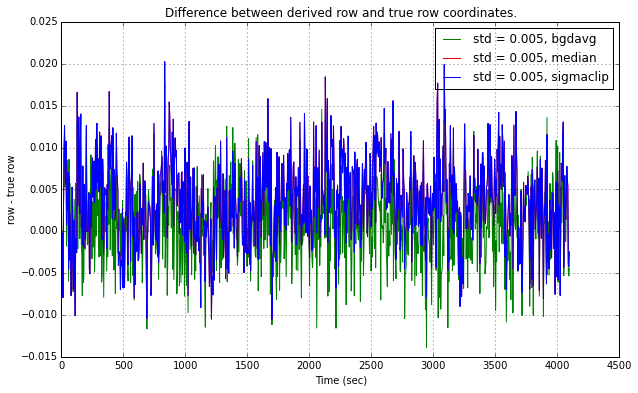

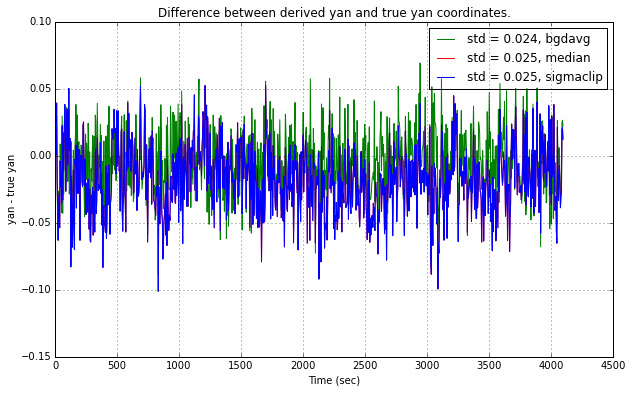

In [33]:
slot = slots[0]
plot_coords_excess(slot, [t_ba, t_m, t_sc], 'row')
plot_coords_excess(slot, [t_ba, t_m, t_sc], 'yan')

__Simulation of a 10.2 mag star with constant background and 1 hot pixel__

In [34]:
hp_number = 3
hp_val = 500
#hot_pixels = simulate_hot_pixels(t_m['time'][0], hp_number, hp_val)

# Test with only one hot pixel
hot_pixels = {(6, 6):500}

print hot_pixels

{(6, 6): 500}


__Patch S/ Survey__

In [20]:
slots = [0]

In [21]:
bgd = StandardBgd()
np.random.seed(42)
rows_ba_hp = centroids(slots, img_size, bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_ba_hp = Table(rows_ba_hp)

Slot = 0


In [25]:
bgd = DynamBgd_Median(img_size=img_size, bgdavg=bgdavg, ndeque=ndeque)
np.random.seed(42)
rows_m_hp = centroids(slots, img_size, bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_m_hp = Table(rows_m_hp)

Slot = 0


In [26]:
bgd = DynamBgd_SigmaClip(img_size=img_size, bgdavg=bgdavg, ndeque=ndeque)
np.random.seed(42)
rows_sc_hp = centroids(slots, img_size, bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_sc_hp = Table(rows_sc_hp)

Slot = 0


In [32]:
# 'Dither' check
row0, col0, yaw, pitch = get_row0col0_yawpitch(t_m_hp['time'][0],
                                               ampl=ampl, period=period, phase=phase)

print np.sum(yaw - row0 > 1), np.sum(pitch - col0 > 1)

0 0


Row0, Col0 indicated in the titles


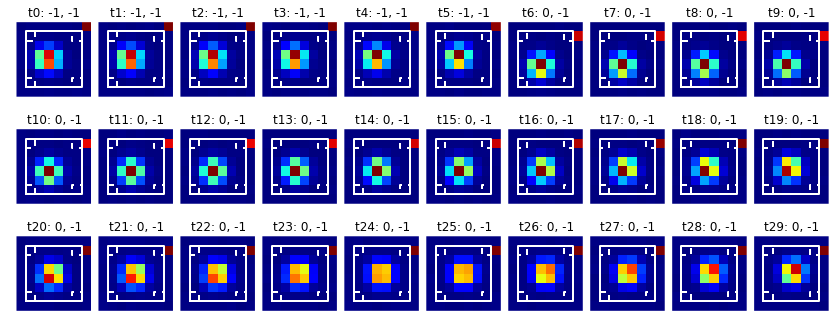

In [30]:
# Plot sequence of the first nimg images, notice the hot pixel in the upper right corner
nimg= 30
fig = plt.figure(figsize=(12, 25))
for i, aa in enumerate(t_m_hp['imgraw'][0][0:nimg]):
    plt.subplot(12, 10, i + 1)
    plot_star_image(aa.reshape(8, 8))
    plt.title('t{}: {}, {}'.format(i, t_ba_hp['row0'][0][i], t_ba_hp['col0'][0][i]));
    plt.axis('off')
print 'Row0, Col0 indicated in the titles'
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.1)

Row0, Col0 indicated in the titles


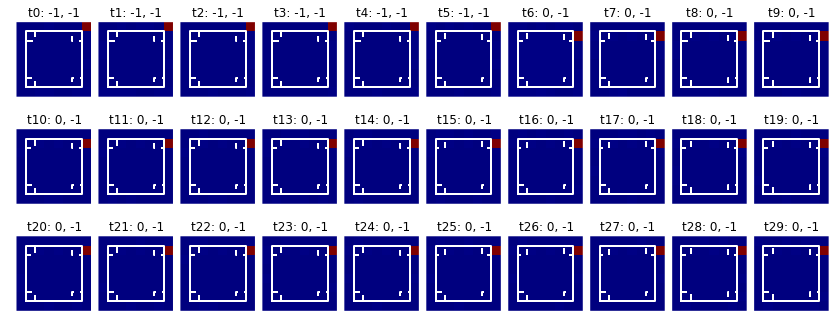

In [31]:
# Plot sequence of the first nbgd background images, notice the hot pixel in the upper right corner
fig = plt.figure(figsize=(12, 25))
nbgd = 30
for i, aa in enumerate(t_sc_hp['bgdimg'][0][0:nbgd]):
    plt.subplot(12, 10, i + 1)
    plot_star_image(aa)
    plt.title('t{}: {}, {}'.format(i, t_ba_hp['row0'][0][i], t_ba_hp['col0'][0][i]));
    plt.axis('off')
print 'Row0, Col0 indicated in the titles'
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.1)

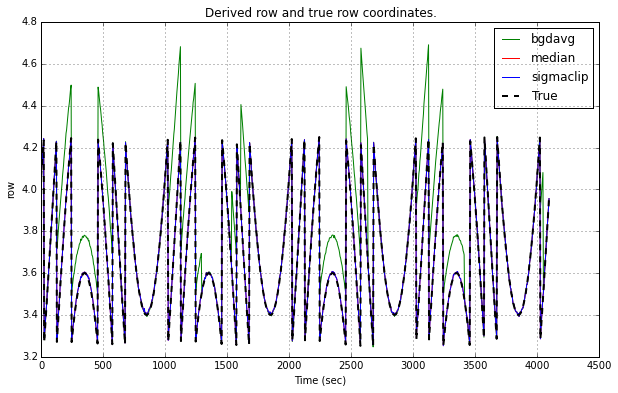

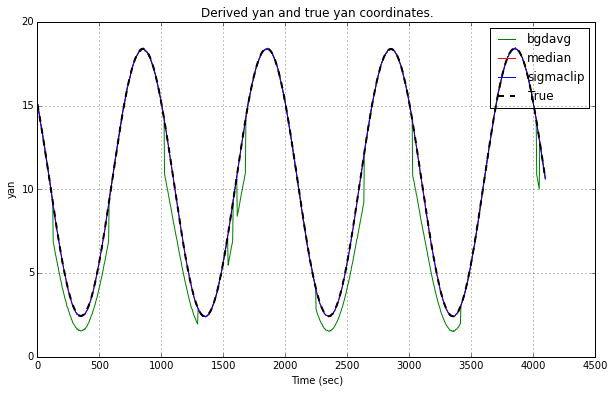

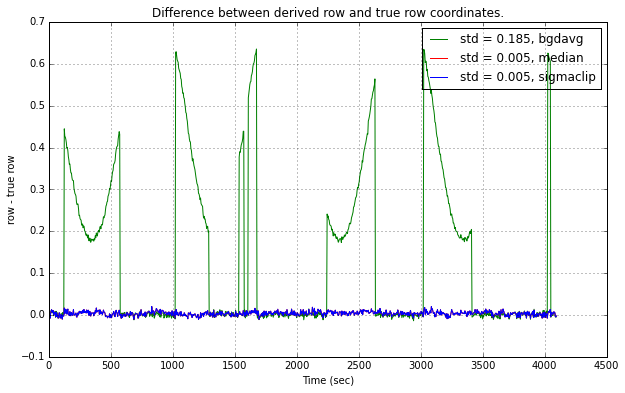

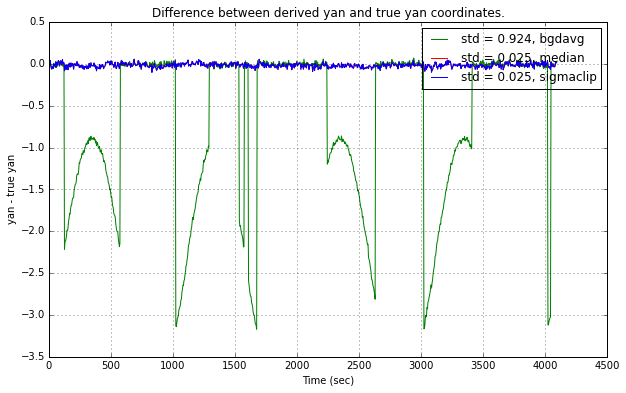

In [35]:
slot = slots[0]
plot_coords(slot, [t_ba_hp, t_m_hp, t_sc_hp], 'row')
plot_coords(slot, [t_ba_hp, t_m_hp, t_sc_hp], 'yan')
plot_coords_excess(slot, [t_ba_hp, t_m_hp, t_sc_hp], 'row')
plot_coords_excess(slot, [t_ba_hp, t_m_hp, t_sc_hp], 'yan')

In [36]:
slots = [0]

### Repeat simulations for a bright 8.2 mag star###

In [46]:
kwargs['mag'] = 8.2

__No hot pixels__

In [39]:
bgd = StandardBgd()
np.random.seed(42)
rows_ba_bri = centroids(slots, img_size, bgd, sim=True, **kwargs)
t_ba_bri = Table(rows_ba_bri)

Slot = 0


In [37]:
bgd = DynamBgd_Median(img_size=img_size, bgdavg=bgdavg, ndeque=ndeque)
np.random.seed(42)
rows_m_bri = centroids(slots, img_size, bgd, sim=True, **kwargs)
t_m_bri = Table(rows_m_bri)

Slot = 0


In [38]:
bgd = DynamBgd_SigmaClip(img_size=img_size, bgdavg=bgdavg, ndeque=ndeque)
np.random.seed(42)
rows_sc_bri = centroids(slots, img_size, bgd, sim=True, **kwargs)
t_sc_bri = Table(rows_sc_bri)

Slot = 0


__1 hot pixel__

In [42]:
bgd = StandardBgd()
np.random.seed(42)
rows_ba_hp_bri = centroids(slots, img_size, bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_ba_hp_bri = Table(rows_ba_hp_bri)

Slot = 0


In [40]:
bgd = DynamBgd_Median(img_size=img_size, bgdavg=bgdavg, ndeque=ndeque)
np.random.seed(42)
rows_m_hp_bri = centroids(slots, img_size, bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_m_hp_bri = Table(rows_m_hp_bri)

Slot = 0


In [41]:
bgd = DynamBgd_SigmaClip(img_size=img_size, bgdavg=bgdavg, ndeque=ndeque)
np.random.seed(42)
rows_sc_hp_bri = centroids(slots, img_size, bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_sc_hp_bri = Table(rows_sc_hp_bri)

Slot = 0


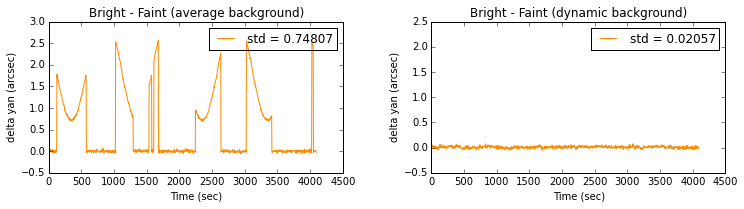

In [50]:
key = 'yan'

fig = plt.figure(figsize=(10, 3))

ylim = (-0.5, 2.5)

plt.subplot(1, 2, 1)
d_ang = t_ba_hp_bri[key][0] - t_ba_hp[key][0]
plt.plot(t_m['time'][0], d_ang, color='Darkorange',
         label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
plt.xlabel('Time (sec)')
plt.ylabel('delta {} (arcsec)'.format(key))
plt.title('Bright - Faint (average background)')
plt.legend()

plt.subplot(1, 2, 2)
t_bri = t_m_hp_bri
t_fai = t_m_hp
d_ang = t_bri[key][0] - t_fai[key][0]
plt.plot(t_sc['time'][0], d_ang, color='Darkorange',
         label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
plt.xlabel('Time (sec)')
plt.ylabel('delta {} (arcsec)'.format(key))
plt.title('Bright - Faint (dynamic background)')
plt.legend()
plt.ylim(ylim)

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)

__Example: real data (HRC)__

In [51]:
# 50804, ACIS, stars in all slots tracked, star in slot 7 faint, all other stars bright
#obsid = 50804
#slots = [2, 4, 7]

# 8912, HRC, stars in all slots tracked, star in slot 3 faint
obsid = 8912
dwell = events.dwells.filter(obsid=obsid)[0]
slots = [3, 4, 5]
img_size = 6

# Define dither parameters
#ampl, period = dither_hrc() # not needed for real data, row0/col0 read from aca_l0 data

In [52]:
msids = ["aoacfct{}".format(slot) for slot in range(8)] + ["aoacmag{}".format(slot) for slot in range(8)]
dat = fetch.MSIDset(msids, start=dwell.start, stop=dwell.stop)

print 'TRAK:'
print [dat[msid].vals.tolist().count('TRAK') for msid in msids[:8]]
print 'RACQ:'
print [dat[msid].vals.tolist().count('RACQ') for msid in msids[:8]]
print 'SRCH:'
print [dat[msid].vals.tolist().count('SRCH') for msid in msids[:8]]
print 'MAG:'
print [np.median(dat[msid].vals) for msid in msids[8:]]

TRAK:
[7983, 7983, 7983, 7983, 7983, 7983, 7983, 7983]
RACQ:
[0, 0, 0, 0, 0, 0, 0, 0]
SRCH:
[0, 0, 0, 0, 0, 0, 0, 0]
MAG:
[6.9375, 7.0, 7.0625, 10.4375, 7.625, 8.875, 9.8125, 7.625]


__Patch D/ Dynamic List: large number of samples__

In [55]:
ndeque = 1000

In [57]:
bgd = StandardBgd()
kwargs['nframes'] = None
rows_hrc_ba = centroids(slots, img_size, bgd, sim=False, **kwargs)

Slot = 3
Slot = 4
Slot = 5


In [61]:
bgd = DynamBgd_Median(img_size=img_size, ndeque=ndeque)
nframes = None
rows_hrc_m = centroids(slots, img_size, bgd, sim=False, **kwargs)

Slot = 3
Slot = 4
Slot = 5


In [59]:
bgd = DynamBgd_SigmaClip(img_size=img_size, ndeque=ndeque)
nframes = None
rows_hrc_sc = centroids(slots, img_size, bgd, sim=False, **kwargs)

Slot = 3
Slot = 4
Slot = 5


In [62]:
t_hrc_ba = Table(rows_hrc_ba)
t_hrc_m = Table(rows_hrc_m)
t_hrc_sc = Table(rows_hrc_sc)

In [63]:
print (t_hrc_ba['time'][1] - t_hrc_ba['time'][2])[:5] # bright - bright
print (t_hrc_ba['time'][1] - t_hrc_ba['time'][0])[:5] # bright - faint

[ 0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.]


Method: average background subtraction


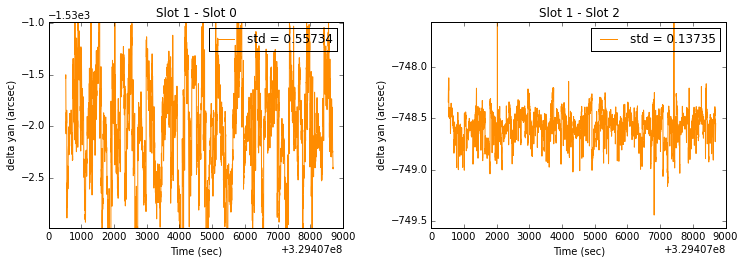

In [65]:
dt = [0., 0.] # shift in sec between time axes for slot pairs (4, 5) and (4, 3)
key = 'yan'
plot_d_ang([0, 2], 1, key, dt, t_hrc_ba)
print "Method: average background subtraction"

Method: dynamic background, median


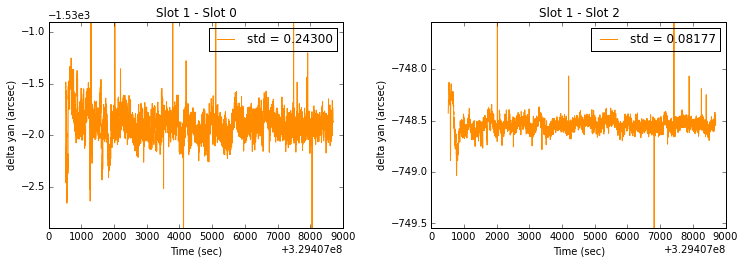

In [66]:
dt = [0., 0.] # shift in sec between time axes for slot pairs (4, 5) and (4, 3)
key = 'yan'
plot_d_ang([0, 2], 1, key, dt, t_hrc_m)
print "Method: dynamic background, median"

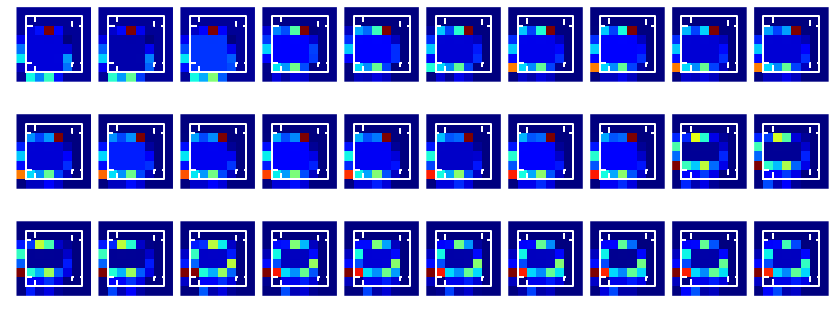

In [77]:
# Plot sequence of the nbgd background images
fig = plt.figure(figsize=(12, 25))
nbgd = 30
for i, aa in enumerate(t_hrc_m['bgdimg'][0][0:nbgd]):
    plt.subplot(12, 10, i + 1)
    plot_star_image(aa)
    plt.title('t{}: {}, {}'.format(i, t_hrc_m['row0'][0][i], t_ba_hp['col0'][0][i]));
    plt.axis('off')
#print 'Row0, Col0 indicated in the titles'
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.1)

Method: dynamic background, sigma clipping


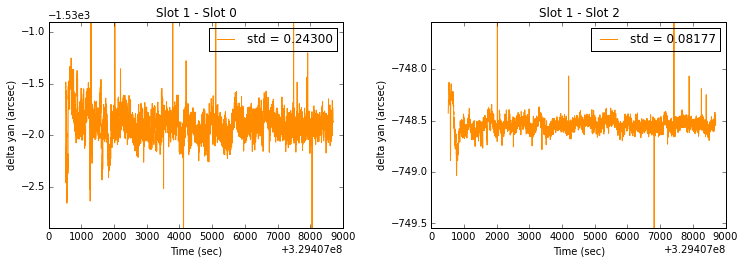

In [67]:
dt = [0., 0.] # shift in sec between time axes for slot pairs  (4, 5) and (4, 3)
key = 'yan'
plot_d_ang([0, 2], 1, key, dt, t_hrc_sc)
print "Method: dynamic background, sigma clipping"

__Patch D/ Dynamic List: small number of samples__

In [69]:
ndeque = 5

In [70]:
bgd = StandardBgd()
kwargs['nframes'] = None
rows_hrc_ba_5 = centroids(slots, img_size, bgd, sim=False, **kwargs)

Slot = 3
Slot = 4
Slot = 5


In [71]:
bgd = DynamBgd_Median(img_size=img_size, ndeque=ndeque)
rows_hrc_m_5 = centroids(slots, img_size, bgd, sim=False, **kwargs)

Slot = 3
Slot = 4
Slot = 5


In [72]:
bgd = DynamBgd_SigmaClip(img_size=img_size, ndeque=ndeque)
rows_hrc_sc_5 = centroids(slots, img_size, bgd, sim=False, **kwargs)

Slot = 3
Slot = 4
Slot = 5


In [73]:
t_hrc_ba_5 = Table(rows_hrc_ba_5)
t_hrc_m_5 = Table(rows_hrc_m_5)
t_hrc_sc_5 = Table(rows_hrc_sc_5)

Method: average background subtraction


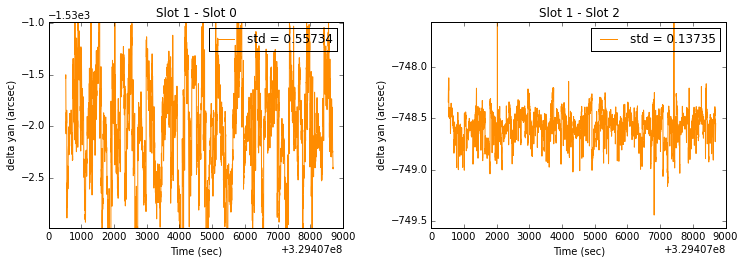

In [74]:
dt = [0., 0.] # shift in sec between time axes for slot pairs (4, 5) and (4, 3)
key = 'yan'
plot_d_ang([0, 2], 1, key, dt, t_hrc_ba_5)
print "Method: average background subtraction"

Method: dynamic background, median


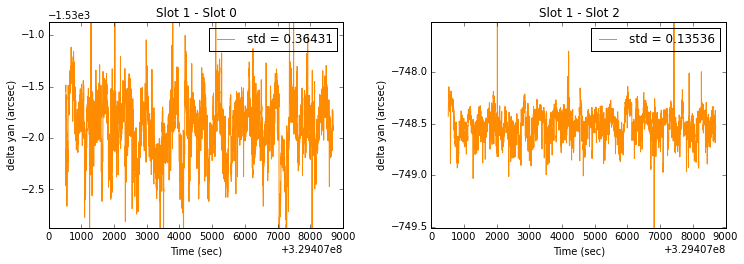

In [75]:
dt = [0., 0.] # shift in sec between time axes for slot pairs (4, 5) and (4, 3)
key = 'yan'
plot_d_ang([0, 2], 1, key, dt, t_hrc_m_5)
print "Method: dynamic background, median"

Method: dynamic background, sigma clipping


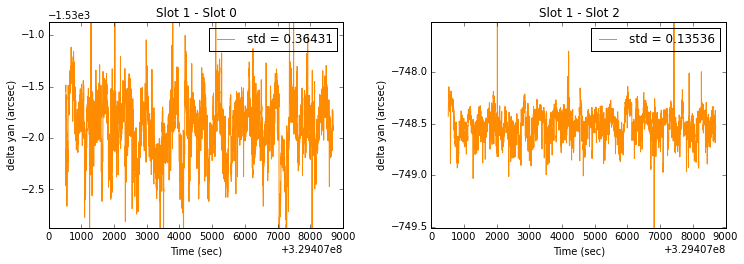

In [76]:
dt = [0., 0.] # shift in sec between time axes for slot pairs (4, 5) and (4, 3)
key = 'yan'
plot_d_ang([0, 2], 1, key, dt, t_hrc_sc_5)
print "Method: dynamic background, sigma clipping"

In [ ]:
# Plot sequence of the nbgd background images
fig = plt.figure(figsize=(12, 25))
nbgd = 30
for i, aa in enumerate(t_hrc_m_5['bgdimg'][0][0:nbgd]):
    plt.subplot(12, 10, i + 1)
    plot_star_image(aa)
    #plt.title('t{}: {}, {}'.format(i, t_hrc_m['row0'][0][i], t_ba_hp['col0'][0][i]));
    plt.axis('off')
#print 'Row0, Col0 indicated in the titles'
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.1)